# VGG 19 Testing

Cody Meng, March 4 2021

Simple playground for testing VGG19

In [ ]:
# Mount google drive, images located in sun_test_images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/Phys\ 477\ -\ Astro\ Project/sun_test_images/171_xray_fits/

/content/drive/Shareddrives/Phys 477 - Astro Project/sun_test_images/171_xray_fits


In [ ]:
!pwd # Check if cd worked right, because it's super finicky with spaces (I only got it to work in its own cell)

/content/drive/Shareddrives/Phys 477 - Astro Project/sun_test_images/171_xray_fits


In [ ]:
# Helper functions
import numpy as np

def downsize(np_img_array, dfactor=2, verbose=False):
  """
  Averages an image numpy array by taking the mean of dfactor pixels along each axis. 
  For example, a 2048x2048 img with dfactor=2 will be downsized into 1024x1024.
  Only the first two image axes must have lengths divisible by dfactor. 
  Image cannot have less than 2 axes or more than 3 axes.

  A (2048,2048,3) img with dfactor = 4 will return a numpy array of shape (512,512,3)
  If verbose, function will print the downsized image shape when complete.
  """

  arrayshape = np_img_array.shape # Get img shape
  if not isinstance(dfactor, int): # Check if dfactor is an integer
    raise TypeError('dfactor must be an integer. Consider using the int() function to cast to integer first.')
  if len(arrayshape) > 3 or len(arrayshape) < 2: # Check if img is 2D or 3D
    raise IndexError('Array must be 2D or 3D; array given is currently %dD'%(len(arrayshape)))
  for axislength in arrayshape[0:2]: # Check if any axes are not divisible by dfactor
    if axislength % dfactor != 0:
      raise ValueError('Axis length %d is not divisible by dfactor = %d'%(axislength, dfactor))

  # Get new shape
  newarrayshape = tuple([int(x/dfactor) for x in arrayshape[0:2]])
  if len(arrayshape) > 2:
    newarrayshape = list(newarrayshape)
    newarrayshape.append(arrayshape[2])
    newarrayshape = tuple(newarrayshape)
    newarray = np.empty(newarrayshape) # Initialize output
    for k in range(newarrayshape[2]):
      for i in range(newarrayshape[0]):
        for j in range(newarrayshape[1]):
          imgslice = np_img_array[dfactor*i:dfactor*(i+1), dfactor*j:dfactor*(j+1), k]
          newarray[i,j,k] = np.mean(imgslice, axis=(0,1)) # Take mean along axes 0 and 1
  else:
    newarray = np.empty(newarrayshape) # Initialize output
    for i in range(newarrayshape[0]):
      for j in range(newarrayshape[1]):
        imgslice = np_img_array[dfactor*i:dfactor*(i+1), dfactor*j:dfactor*(j+1)]
        newarray[i,j] = np.mean(imgslice, axis=(0,1)) # Take mean along axes 0 and 1

  if verbose:
    print("Downsizing Done, new array size " + str(newarray.shape))
  return newarray

# Testing
array0 = np.ones((512,512,3))
#array1 = np.array([[[1,1],[1,1],[2,2],[2,2]],[[3,3],[3,3],[4,4],[4,4]]])
#print(array1.shape)

#downsize(array0)
downsized0 = downsize(array0, 4, verbose=True)


Downsizing Done, new array size (128, 128, 3)


In [ ]:
# Open sample fits file
from astropy.io import fits
import matplotlib.pyplot as plt

# hdulist
hdul171 = fits.open("aia_lev1_171a_2015_01_01t05_09_35_34z_image_lev1.fits")
#hdul1.info()

# extract header and data
header171 = hdul171[1].header
data171 = hdul171[1].data
#display(header1)   #2d 4096x4096 array

# (Optional) Downsize the image for faster processing
dfactor = 16 # Downsizing factor
downsized171 = downsize(data171, dfactor=dfactor, verbose=True)  # Convert to 1024x1024 by averaging

# Convert image to RGB greyscale by cloning the image in all 3 channels
img171_3d = np.repeat(downsized171[:, :, np.newaxis], 3, axis=2) 
print(img171_3d.shape)

Downsizing Done, new array size (256, 256)
(256, 256, 3)


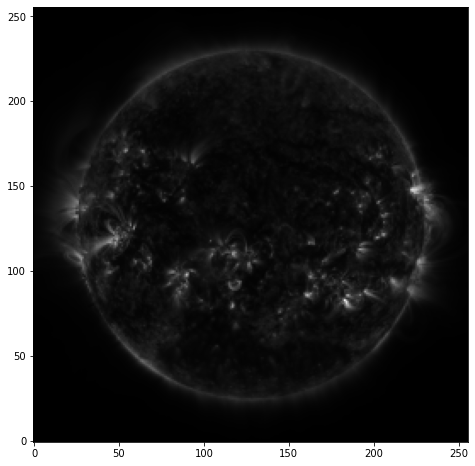

(1, 256, 256, 3)


In [ ]:
#img171 = downsized1.reshape((int(4096/dfactor),int(4096/dfactor), 3))
#print(img1.shape)

plt.subplots(figsize=(8,8))
plt.imshow(img171_3d[:,:,0], origin='lower', cmap="gray")
plt.show()

imglist = np.array([img171_3d])
print(imglist.shape)


In [ ]:
# Import requisite packages
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
#from keras.preprocessing.image import load_img  #<- this is for loading things like jpeg.

model = VGG19(include_top=False, input_shape=(512,512,3))   # Downloads the weights for the VGG19 model the first time you run it  
# [This step probably needs to be modified to fix the bottom issue. It is missing the final four steps present
#  in the default model, which flattens and turns the weights into an actual list of probabilities. Not sure
#  how to fix this yet.]

# From CT: Dense() function is key here, to convert smaller image into 1x1000 vector, which gets densed again into a class vector
# Look at activation functions, etc. from VGG19
# Less Cross-entropy (?)
# Figure out how many convpools you need
# blosc is probably the compression you want


print(model.summary())  
# Prints some basic info about the VGG19 model. Notably, the input layer expects
# 224 x 224 RGB images by default, given its shape. I set input shape to 512x512.

# Do keras image preprocessing, which is just an RGB mean subtraction. Must be done on a list of 3D images
final_imglist = preprocess_input(imglist) 

# Make a Keras prediction. Must be done on a list of 3D images
yhat = model.predict(final_imglist)

# Decode the predictions
label = decode_predictions(yhat) # Convert probabilities to class labels [NOT WORKING]
label = label[0][0] # retrieve the most likely result

# Print Classification
print('%s (%.2f%%)'%(label[1], label[2]*100))


80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
______________________________________________________________

ValueError: ignored

In [ ]:
defaultmodel = VGG19()
print(defaultmodel.summary())  # This shows the architecture of the default VGG19 CNN